In [1]:
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

from a_api import TextMetrics, load_ngrams
from plot import plot_dict, plot_dict_bars, matrix_plot
from util import dictcount

grand_t0 = dt.datetime.now()

# Create Datasets
## Merge original binary and multiclass datasets into one

In [2]:
# Dataset: Unclassified distortions (halilbabacan)
# Paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4582307
# Data: https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/tree/main/raw
# https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/blob/main/raw/Cognitive_distortions.csv
    
binary_dataset_file_path = "../../data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

In [3]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

# !pip install kagglehub
import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"


Path to dataset files: C:\Users\anton\.cache\kagglehub\datasets\sagarikashreevastava\cognitive-distortion-detetction-dataset\versions\1


In [4]:
df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)l", value = np.nan)
df1

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
3522,Since then whenever my mother is out alone I b...,NaN,Distortion,NaN
3523,My family hate him but they didn’t met him at ...,NaN,Distortion,NaN
3524,However I am not happy at the least only half ...,NaN,Distortion,NaN
3525,Now I am at university my peers around me all ...,NaN,Distortion,NaN


In [5]:
df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 
df2

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [6]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)l,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN,NaN
...,...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,NaN,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN,NaN


## Create 3 split datasets for evaluation

### Evaluate new split models individually for each of 3 parts against the models learned on the other 2 parts 
- parts
  - part1 = df[df.index % 3 == 1] # dfs[1] - test on model from third_split
  - part2 = df[df.index % 3 == 2] # dfs[2] - test on model from second_split
  - part3 = df[df.index % 3 == 0] # dfs[0] - test on model from first_split
- train-test splits
  - (pd.concat([part1, part2]), part3),  # first_split:  (1 + 2) -> train, (3) -> test
  - (pd.concat([part1, part3]), part2),  # second_split: (1 + 3) -> train, (2) -> test
  - (pd.concat([part2, part3]), part1)   # third_split:  (2 + 3) -> train, (1) -> test

In [7]:
df3s = [ df3.iloc[:0,:].copy(), df3.iloc[:0,:].copy(), df3.iloc[:0,:].copy()]

row_n = 0 
for _, row in df3.iterrows():
    r3 = row_n % 3
    row_n += 1
    df = df3s[r3]
    df.loc[len(df)] = row

print(len(df3))
for df in df3s:
    print(len(df))

6057
2019
2019
2019


In [8]:
part1 = df3s[1]
part2 = df3s[2]
part3 = df3s[0]
splits = { # train, test
    'first_split':(pd.concat([part1, part2]), part3),
    'second_split':(pd.concat([part1, part3]), part2),
    'third_split':(pd.concat([part2, part3]), part1)
}

# Create Evaluation Functions

In [9]:
def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + m + '.txt'
    return metrics

def our_evaluator_tm_any(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_tm_avg(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False

def our_evaluator_tm_true(tm,text,threshold):
    return True
    
def our_evaluator_tm_false(tm,text,threshold):
    return False

def our_evaluator_tm_random(tm,text,threshold):
    return random.choice([True, False])

def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_tm_df_counts(df,tm,evaluator,threshold,debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(tm,text,threshold)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_tm_df(df,evaluator,threshold,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,tm,evaluator,threshold,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def evaluate_tm_df_acc_f1(df,tm,evaluator,threshold,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_tm_df_counts(df,tm,evaluator,threshold,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 


In [10]:
root_path = '../../data/models/distortions/split_combined/multiclass_view_cleaned/'
if not os.path.exists(root_path+'joint'):
    os.makedirs(root_path+'joint')
unionset_files = {}
for split_name in ['first_split','second_split','third_split']:
    split_path = root_path+split_name+'/'
    print(split_path)
    files = os.listdir(split_path)
    print(files)
    for file in files:
        if not file in unionset_files:
            unionset_files[file] = {}
        union = unionset_files[file]
        ngrams = load_ngrams(split_path+file,encoding="utf-8")
        for ngram in ngrams:
            dictcount(union,ngram)
for file in unionset_files:
    cross = set()
    union = unionset_files[file]
    for ngram in union:
        if union[ngram] >= 3:
            cross.add(ngram)
    with open(root_path+'joint/'+file, "w", encoding="utf-8") as f:
        for ngram in cross:
            ngram_str = ' '.join(ngram)
            f.write(f"{ngram_str}\n")
    

../../data/models/distortions/split_combined/multiclass_view_cleaned/first_split/
['All-or-nothing_thinking.txt', 'Distortion.txt', 'Emotional_Reasoning.txt', 'Fortune-telling.txt', 'Labeling.txt', 'Magnification.txt', 'Mental_filter.txt', 'Mind_Reading.txt', 'No_Distortion.txt', 'Overgeneralization.txt', 'Personalization.txt', 'Should_statements.txt']
../../data/models/distortions/split_combined/multiclass_view_cleaned/second_split/
['All-or-nothing_thinking.txt', 'Distortion.txt', 'Emotional_Reasoning.txt', 'Fortune-telling.txt', 'Labeling.txt', 'Magnification.txt', 'Mental_filter.txt', 'Mind_Reading.txt', 'No_Distortion.txt', 'Overgeneralization.txt', 'Personalization.txt', 'Should_statements.txt']
../../data/models/distortions/split_combined/multiclass_view_cleaned/third_split/
['All-or-nothing_thinking.txt', 'Distortion.txt', 'Emotional_Reasoning.txt', 'Fortune-telling.txt', 'Labeling.txt', 'Magnification.txt', 'Mental_filter.txt', 'Mind_Reading.txt', 'No_Distortion.txt', 'Overgen

In [11]:
root_path = '../../data/models/distortions/split_combined/binary_view_cleaned/'
if not os.path.exists(root_path+'joint'):
    os.makedirs(root_path+'joint')
unionset_files = {}
for split_name in ['first_split','second_split','third_split']:
    split_path = root_path+split_name+'/'
    print(split_path)
    files = os.listdir(split_path)
    print(files)
    for file in files:
        if not file in unionset_files:
            unionset_files[file] = {}
        union = unionset_files[file]
        ngrams = load_ngrams(split_path+file,encoding="utf-8")
        for ngram in ngrams:
            dictcount(union,ngram)
for file in unionset_files:
    cross = set()
    union = unionset_files[file]
    for ngram in union:
        if union[ngram] >= 3:
            cross.add(ngram)
    with open(root_path+'joint/'+file, "w", encoding="utf-8") as f:
        for ngram in cross:
            ngram_str = ' '.join(ngram)
            f.write(f"{ngram_str}\n")


../../data/models/distortions/split_combined/binary_view_cleaned/first_split/
['Distortion.txt', 'No_Distortion.txt']
../../data/models/distortions/split_combined/binary_view_cleaned/second_split/
['Distortion.txt', 'No_Distortion.txt']
../../data/models/distortions/split_combined/binary_view_cleaned/third_split/
['Distortion.txt', 'No_Distortion.txt']


In [12]:
models = {}

In [13]:
models['Ours base (binary: distortions and emotions), log'] = TextMetrics(language_metrics('',['distortions-all-emotions'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

In [14]:
models['Ours base (binary: distortions and negative emotions), log'] = TextMetrics(language_metrics('',['distortions-negative-emotions'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

In [15]:
models['Ours base (binary: distortions only), log'] = TextMetrics(language_metrics('',['distortions-only'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

In [16]:
models['Ours base (multi-class: distortions and emotions), log'] = TextMetrics(language_metrics('',['positive','negative','rude',
                                            'catastrophizing','dichotomous-reasoning','disqualifying-positive','emotional-reasoning',
                                            'fortune-telling','labeling','magnification','mental-filtering','mindreading',
                                            'overgeneralizing','personalizing','should-statement'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

models['Ours base (multi-class: distortions and emotions), no log'] = TextMetrics(language_metrics('',['positive','negative','rude',
                                            'catastrophizing','dichotomous-reasoning','disqualifying-positive','emotional-reasoning',
                                            'fortune-telling','labeling','magnification','mental-filtering','mindreading',
                                            'overgeneralizing','personalizing','should-statement'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=False,debug=False)

In [17]:
models['Ours new (binary), log'] = TextMetrics(language_metrics('',['Distortion'],
                                            path='../../data/models/distortions/overfitting_combined/binary_view/'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (binary), no log'] = TextMetrics(language_metrics('',['Distortion'],
                                            path='../../data/models/distortions/overfitting_combined/binary_view/'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)

models['Ours new (binary, clean), log'] = TextMetrics(language_metrics('',['Distortion'],
                                            path='../../data/models/distortions/overfitting_combined/binary_view_cleaned/'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (binary, clean), no log'] = TextMetrics(language_metrics('',['Distortion'],
                                            path='../../data/models/distortions/overfitting_combined/binary_view_cleaned/'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)

models['Ours new (binary, joint), log'] = TextMetrics(language_metrics('',['Distortion'],
                                            path='../../data/models/distortions/split_combined/binary_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (binary, joint), no log'] = TextMetrics(language_metrics('',['Distortion'],
                                            path='../../data/models/distortions/split_combined/binary_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)


In [18]:
models['Ours new (multi-class), log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/overfitting_combined/multiclass_view/'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (multi-class), no log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/overfitting_combined/multiclass_view/'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)

models['Ours new (multi-class, clean), log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/overfitting_combined/multiclass_view_cleaned/'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (multi-class, clean), no log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/overfitting_combined/multiclass_view_cleaned/'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)

models['Ours new (multi-class, joint), log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/split_combined/multiclass_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (multi-class, joint), no log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/split_combined/multiclass_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)


# Evaluate Different Models
## Evaluate All "Ours" Models without of Splits


In [19]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
models_results = {}
models_acc = []
models_f1 = []


In [20]:
for model in [m for m in models]:
    print(model)
    best_t = 0
    best_acc = 0
    best_f1 = 0
    res_acc = {}
    res_f1 = {}
    for t in thresholds:
        acc, f1 = evaluate_tm_df_acc_f1(df3,models[model],our_evaluator_tm_any,t,debug=False)
        if acc > best_acc:
            best_t = t
            best_acc = acc
            best_f1 = f1
        res_acc[t] = acc
        res_f1[t] = f1
        print(model, t, acc, f1)
    models_acc.append([round(res_acc[t],2) for t in thresholds])
    models_f1.append([round(res_f1[t],2) for t in thresholds])
    t0 = dt.datetime.now()
    acc, f1 = evaluate_tm_df_acc_f1(df3,models[model],our_evaluator_tm_any,best_t,debug=False)
    t1 = dt.datetime.now()
    delta = t1 - t0
    print(model, best_t, best_acc, best_f1, delta.total_seconds(), delta.total_seconds()/len(df3) )
    models_results[model + ', any'] = ( 'any', best_t, best_acc, best_f1, delta.total_seconds(), delta.total_seconds()/len(df3) )
assert len([r for r in models_results]) == len(models_acc)

Ours base (binary: distortions and emotions), log
Ours base (binary: distortions and emotions), log 0.1 0.686313356447086 0.8139808106520462
Ours base (binary: distortions and emotions), log 0.2 0.686313356447086 0.8139808106520462
Ours base (binary: distortions and emotions), log 0.3 0.686313356447086 0.8138714733542319
Ours base (binary: distortions and emotions), log 0.4 0.6823509988443124 0.8105180224542051
Ours base (binary: distortions and emotions), log 0.5 0.6764074624401519 0.8007320048800326
Ours base (binary: distortions and emotions), log 0.6 0.7021627868581806 0.7865088757396449
Ours base (binary: distortions and emotions), log 0.7 0.5804853888063398 0.5727257440726417
Ours base (binary: distortions and emotions), log 0.8 0.3607396400858511 0.14146341463414633
Ours base (binary: distortions and emotions), log 0.9 0.30873369654944693 0.001907032181168057
Ours base (binary: distortions and emotions), log 0.6 0.7021627868581806 0.7865088757396449 1.683889 0.000278007099224038

In [21]:
for model in [m for m in models if 'multi-class' in m]:
    print(model)
    best_t = 0
    best_acc = 0
    best_f1 = 0
    res_acc = {}
    res_f1 = {}
    for t in thresholds:
        acc, f1 = evaluate_tm_df_acc_f1(df3,models[model],our_evaluator_tm_avg,t,debug=False)
        if acc > best_acc:
            best_t = t
            best_acc = acc
            best_f1 = f1
        res_acc[t] = acc
        res_f1[t] = f1
        print(model, t, acc, f1)
    models_acc.append([round(res_acc[t],2) for t in thresholds])
    models_f1.append([round(res_f1[t],2) for t in thresholds])
    t0 = dt.datetime.now()
    acc, f1 = evaluate_tm_df_acc_f1(df3,models[model],our_evaluator_tm_avg,best_t,debug=False)
    t1 = dt.datetime.now()
    delta = t1 - t0
    print(model, best_t, best_acc, best_f1, delta.total_seconds(), delta.total_seconds()/len(df3) )
    models_results[model + ', avg'] = ( 'avg', best_t, best_acc, best_f1, delta.total_seconds(), delta.total_seconds()/len(df3) )
assert len([r for r in models_results]) == len(models_acc)

Ours base (multi-class: distortions and emotions), log
Ours base (multi-class: distortions and emotions), log 0.1 0.686313356447086 0.8139808106520462
Ours base (multi-class: distortions and emotions), log 0.2 0.687964338781575 0.814778518228146
Ours base (multi-class: distortions and emotions), log 0.3 0.755489516262176 0.8473667937751211
Ours base (multi-class: distortions and emotions), log 0.4 0.8025425127951131 0.8509471585244267
Ours base (multi-class: distortions and emotions), log 0.5 0.5813108799735843 0.571041948579161
Ours base (multi-class: distortions and emotions), log 0.6 0.3675086676572561 0.15894621295279912
Ours base (multi-class: distortions and emotions), log 0.7 0.3179791976225854 0.02822865208186309
Ours base (multi-class: distortions and emotions), log 0.8 0.31038467888393595 0.006658739595719382
Ours base (multi-class: distortions and emotions), log 0.9 0.30807330361565133 0
Ours base (multi-class: distortions and emotions), log 0.4 0.8025425127951131 0.85094715

In [22]:
for result in models_results:
    print(models_results[result],model)


('any', 0.6, 0.7021627868581806, 0.7865088757396449, 1.683889, 0.0002780070992240383) Ours new (multi-class, joint), no log
('any', 0.5, 0.6775631500742942, 0.7676935886761032, 1.607723, 0.0002654322271751692) Ours new (multi-class, joint), no log
('any', 0.3, 0.5960046227505366, 0.6572349068496989, 1.471691, 0.00024297358428264818) Ours new (multi-class, joint), no log
('any', 0.5, 0.7054647515271587, 0.773143438453713, 3.324116, 0.0005488056793792307) Ours new (multi-class, joint), no log
('any', 0.1, 0.6854878652798415, 0.7375671580107453, 3.247057, 0.0005360833746078917) Ours new (multi-class, joint), no log
('any', 0.4, 0.9993396070662044, 0.9995225590833136, 1.450219, 0.00023942859501403335) Ours new (multi-class, joint), no log
('any', 0.1, 0.9993396070662044, 0.9995225590833136, 1.25739, 0.000207592867756315) Ours new (multi-class, joint), no log
('any', 0.4, 0.9993396070662044, 0.9995225590833136, 1.51492, 0.0002501106158164108) Ours new (multi-class, joint), no log
('any', 0.

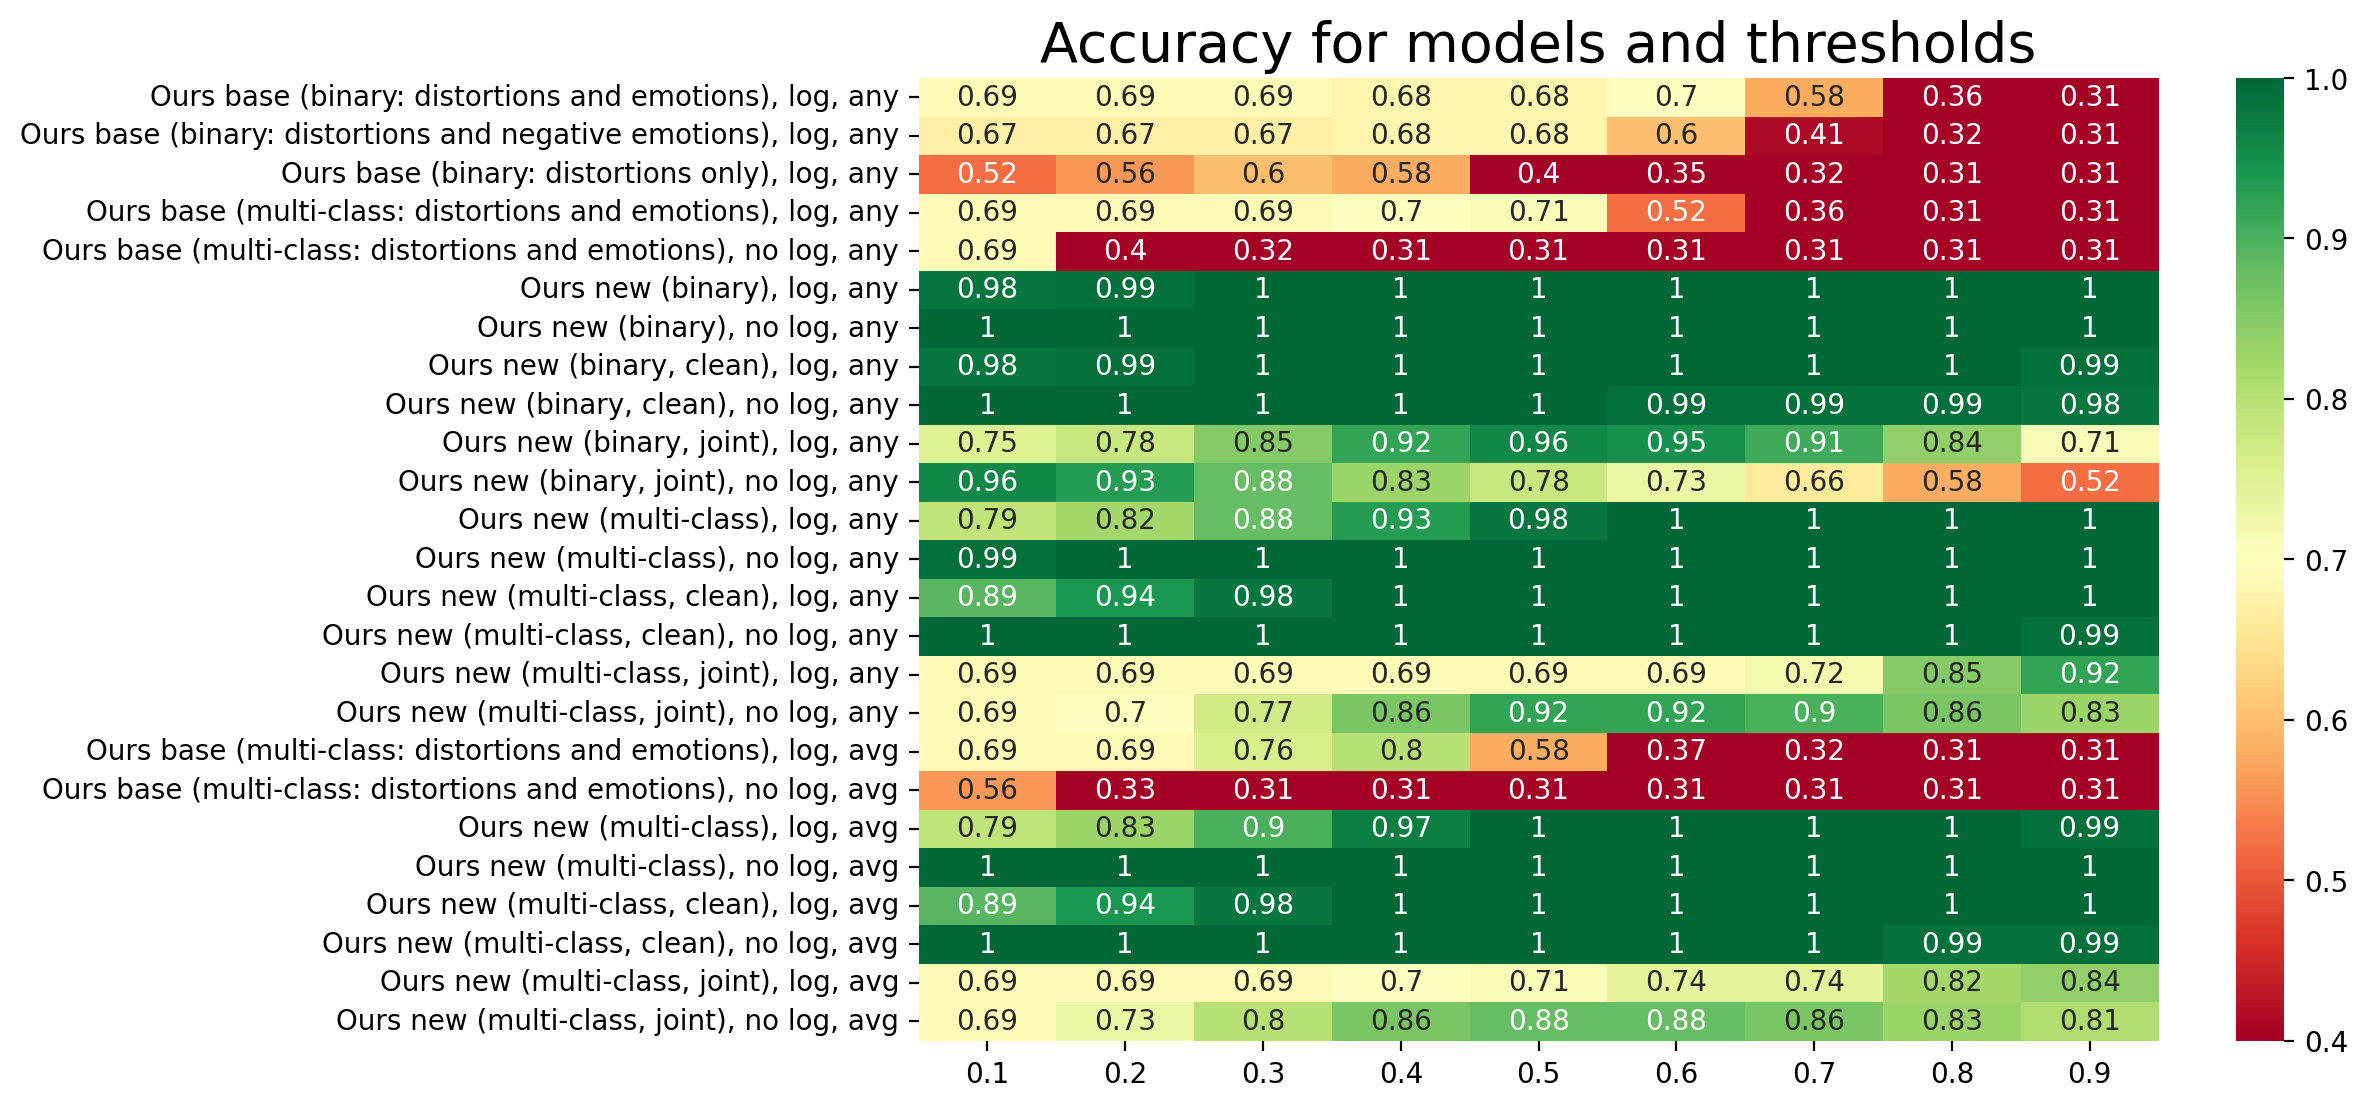

In [23]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title = None, vmin = None, vmax = None, dpi = None, titlefontsize = None, width = 20):
    plt.rcParams["figure.figsize"] = (width,len(row_labels)/4)
    if not dpi is None:
        plt.rcParams["figure.dpi"] = dpi
    p = sns.heatmap(matrix, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin = -absmax if vmin is None else vmin, 
                    vmax = absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        p.set_title(title,fontsize = titlefontsize)
    plt.show()


matrix_plot([m for m in models_results], thresholds, models_acc, 1.0, title = 'Accuracy for models and thresholds', 
            vmin = 1.0-(1.0-0.7)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

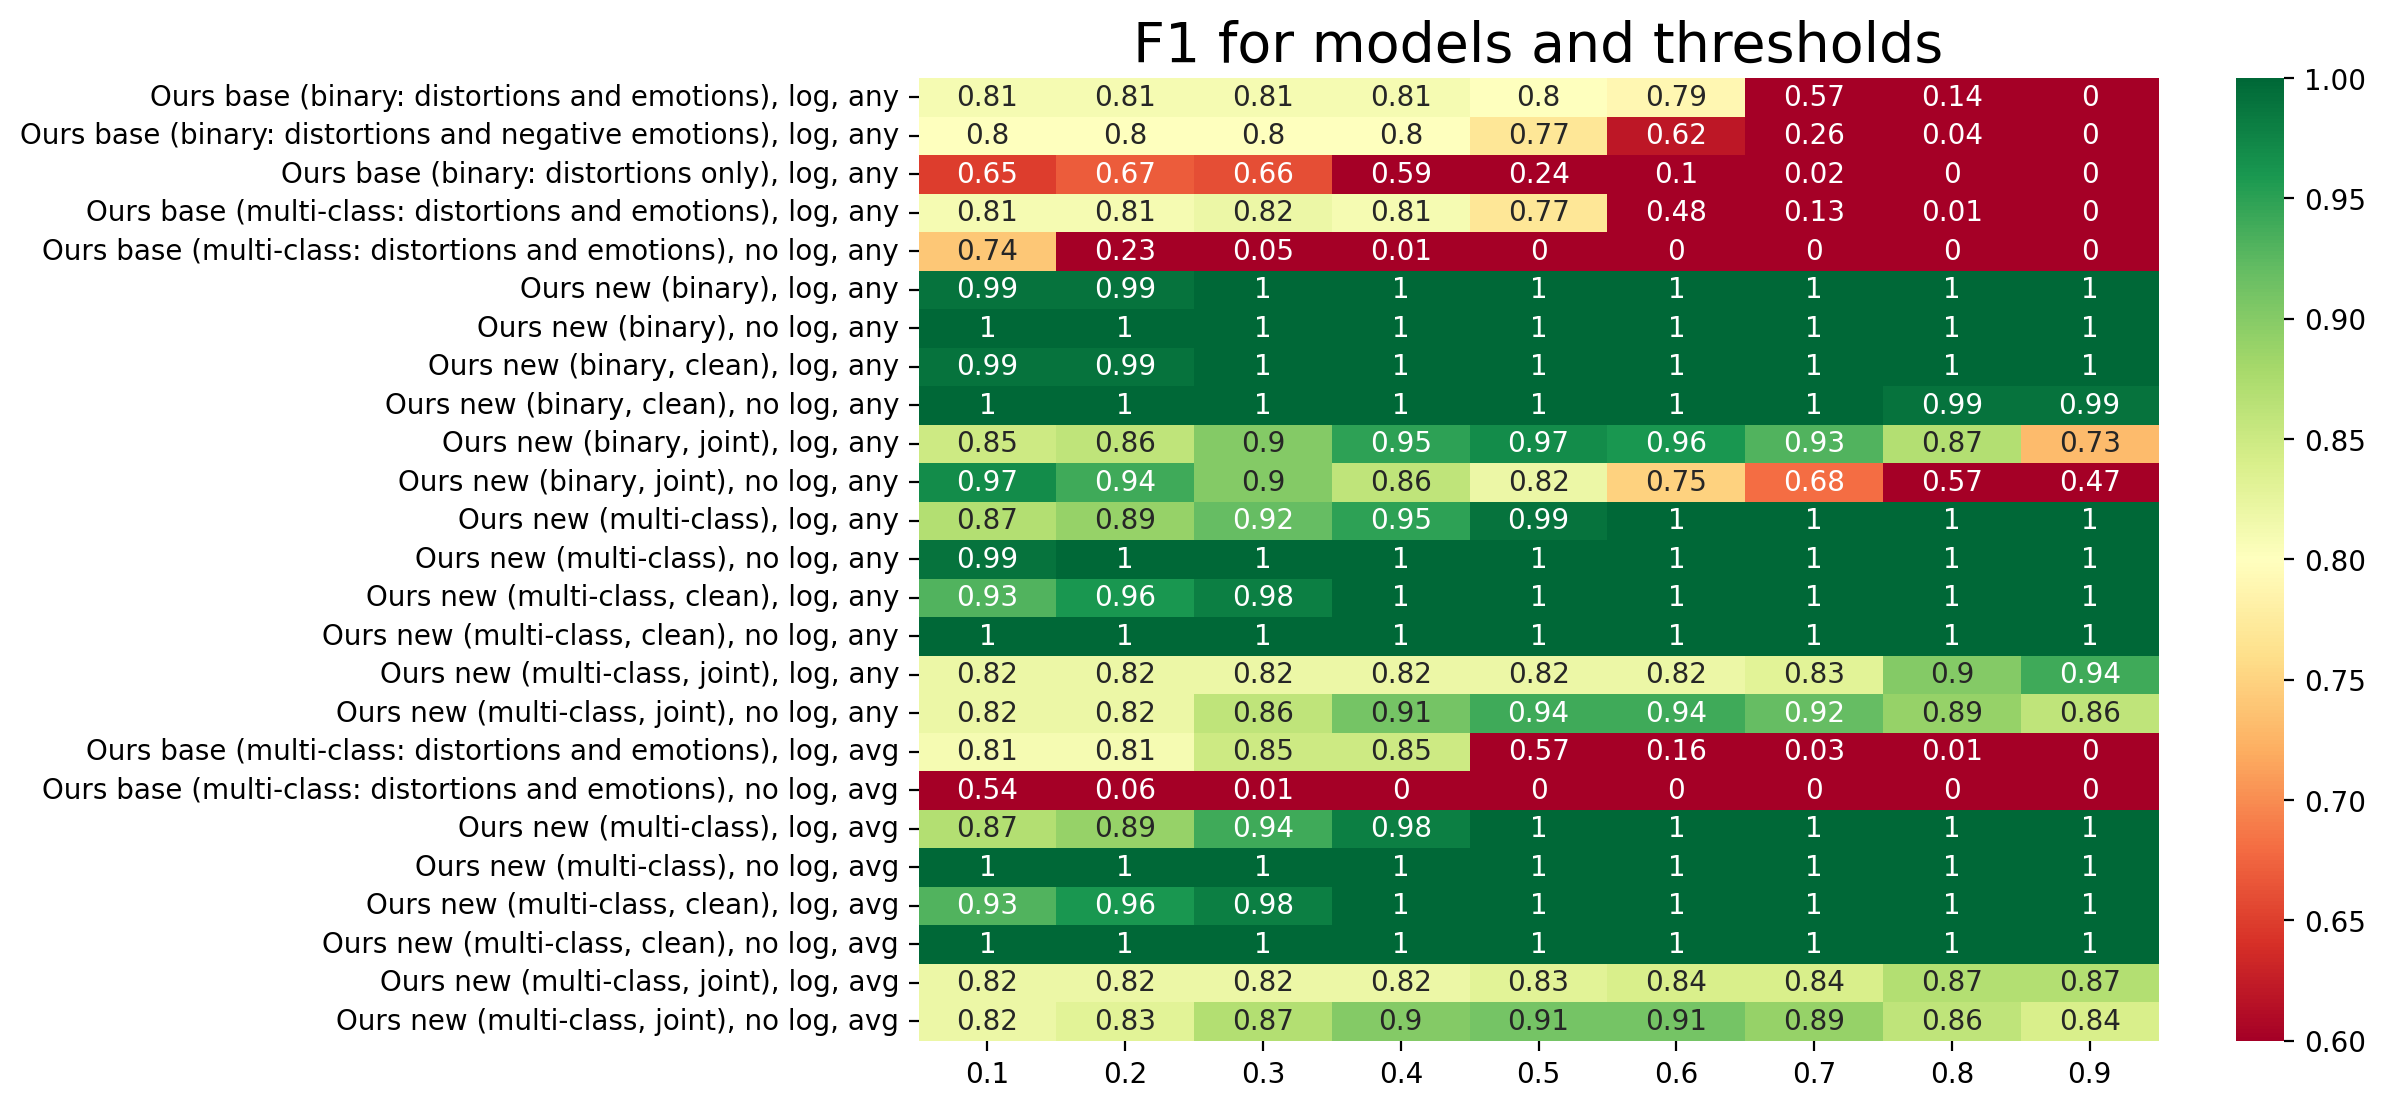

In [24]:
matrix_plot([m for m in models_results], thresholds, models_f1, 1.0, title = 'F1 for models and thresholds', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

In [25]:
for i in range(len(models_results)):
    model = [m for m in models_results][i]
    row = models_acc[i]
    maxt = 0
    maxacc = 0
    for col in range(len(row)):
        if row[col] > maxacc:
            maxacc = row[col]
            maxt = thresholds[col]
    if maxacc >= 0.8:
        print(maxacc,maxt,model)

1.0 0.3 Ours new (binary), log, any
1.0 0.1 Ours new (binary), no log, any
1.0 0.3 Ours new (binary, clean), log, any
1.0 0.1 Ours new (binary, clean), no log, any
0.96 0.5 Ours new (binary, joint), log, any
0.96 0.1 Ours new (binary, joint), no log, any
1.0 0.6 Ours new (multi-class), log, any
1.0 0.2 Ours new (multi-class), no log, any
1.0 0.4 Ours new (multi-class, clean), log, any
1.0 0.1 Ours new (multi-class, clean), no log, any
0.92 0.9 Ours new (multi-class, joint), log, any
0.92 0.5 Ours new (multi-class, joint), no log, any
0.8 0.4 Ours base (multi-class: distortions and emotions), log, avg
1.0 0.5 Ours new (multi-class), log, avg
1.0 0.1 Ours new (multi-class), no log, avg
1.0 0.4 Ours new (multi-class, clean), log, avg
1.0 0.1 Ours new (multi-class, clean), no log, avg
0.84 0.9 Ours new (multi-class, joint), log, avg
0.88 0.5 Ours new (multi-class, joint), no log, avg


In [26]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'0:09:28.580627'